In [2]:
import os 
if 'notebooks' in os.getcwd():
    os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Getting datasets

In [3]:
prices0 = pd.read_csv(
    "data/round3/prices_round_3_day_0.csv",
    sep = ';'
)

prices1 = pd.read_csv(
    "data/round3/prices_round_3_day_1.csv",
    sep = ';'
)

prices2 = pd.read_csv(
    "data/round3/prices_round_3_day_2.csv",
    sep = ';'
)

In [4]:
diving_gear0 = prices0\
    .query("product == 'DIVING_GEAR'")\
    .set_index("timestamp")
dolphin_sightins0 = prices0\
    .query("product == 'DOLPHIN_SIGHTINGS'")\
    .set_index("timestamp")

diving_gear1 = prices1\
    .query("product == 'DIVING_GEAR'")\
    .set_index("timestamp")
dolphin_sightins1 = prices1\
    .query("product == 'DOLPHIN_SIGHTINGS'")\
    .set_index("timestamp")

diving_gear2 = prices2\
    .query("product == 'DIVING_GEAR'")\
    .set_index("timestamp")
dolphin_sightins2 = prices2\
    .query("product == 'DOLPHIN_SIGHTINGS'")\
    .set_index("timestamp")

In [5]:
mask = diving_gear0.columns.str.contains("bid_volume")
diving_gear0[diving_gear0.columns[mask]]\
    .sum(axis=1)\
    .describe()

count    10000.000000
mean        22.470800
std          3.618239
min         12.000000
25%         20.000000
50%         22.000000
75%         25.000000
max         33.000000
dtype: float64

In [6]:
dolphin_feature0 = dolphin_sightins0['mid_price']
dolphin_signal0 = dolphin_feature0.pct_change(1).fillna(0)
diving_gear_prices0 = diving_gear0['mid_price']

dolphin_feature1 = dolphin_sightins1['mid_price']
dolphin_signal1 = dolphin_feature1.pct_change(1).fillna(0)
diving_gear_prices1 = diving_gear1['mid_price']

dolphin_feature2 = dolphin_sightins2['mid_price']
dolphin_signal2 = dolphin_feature2.pct_change(1).fillna(0)
diving_gear_prices2 = diving_gear2['mid_price']

In [7]:
# Getting the indexes of buy and sell signals from dolphin

buy_signal0 = list(dolphin_signal0[(dolphin_signal0 > 0.002)].index)
sell_signal0 = list(dolphin_signal0[(dolphin_signal0 < -0.002)].index)

buy_signal1 = list(dolphin_signal1[(dolphin_signal1 > 0.002)].index)
sell_signal1 = list(dolphin_signal1[(dolphin_signal1 < -0.002)].index)

buy_signal2 = list(dolphin_signal2[(dolphin_signal2 > 0.002)].index)
sell_signal2 = list(dolphin_signal2[(dolphin_signal2 < -0.002)].index)

# Identifying dolphing signal

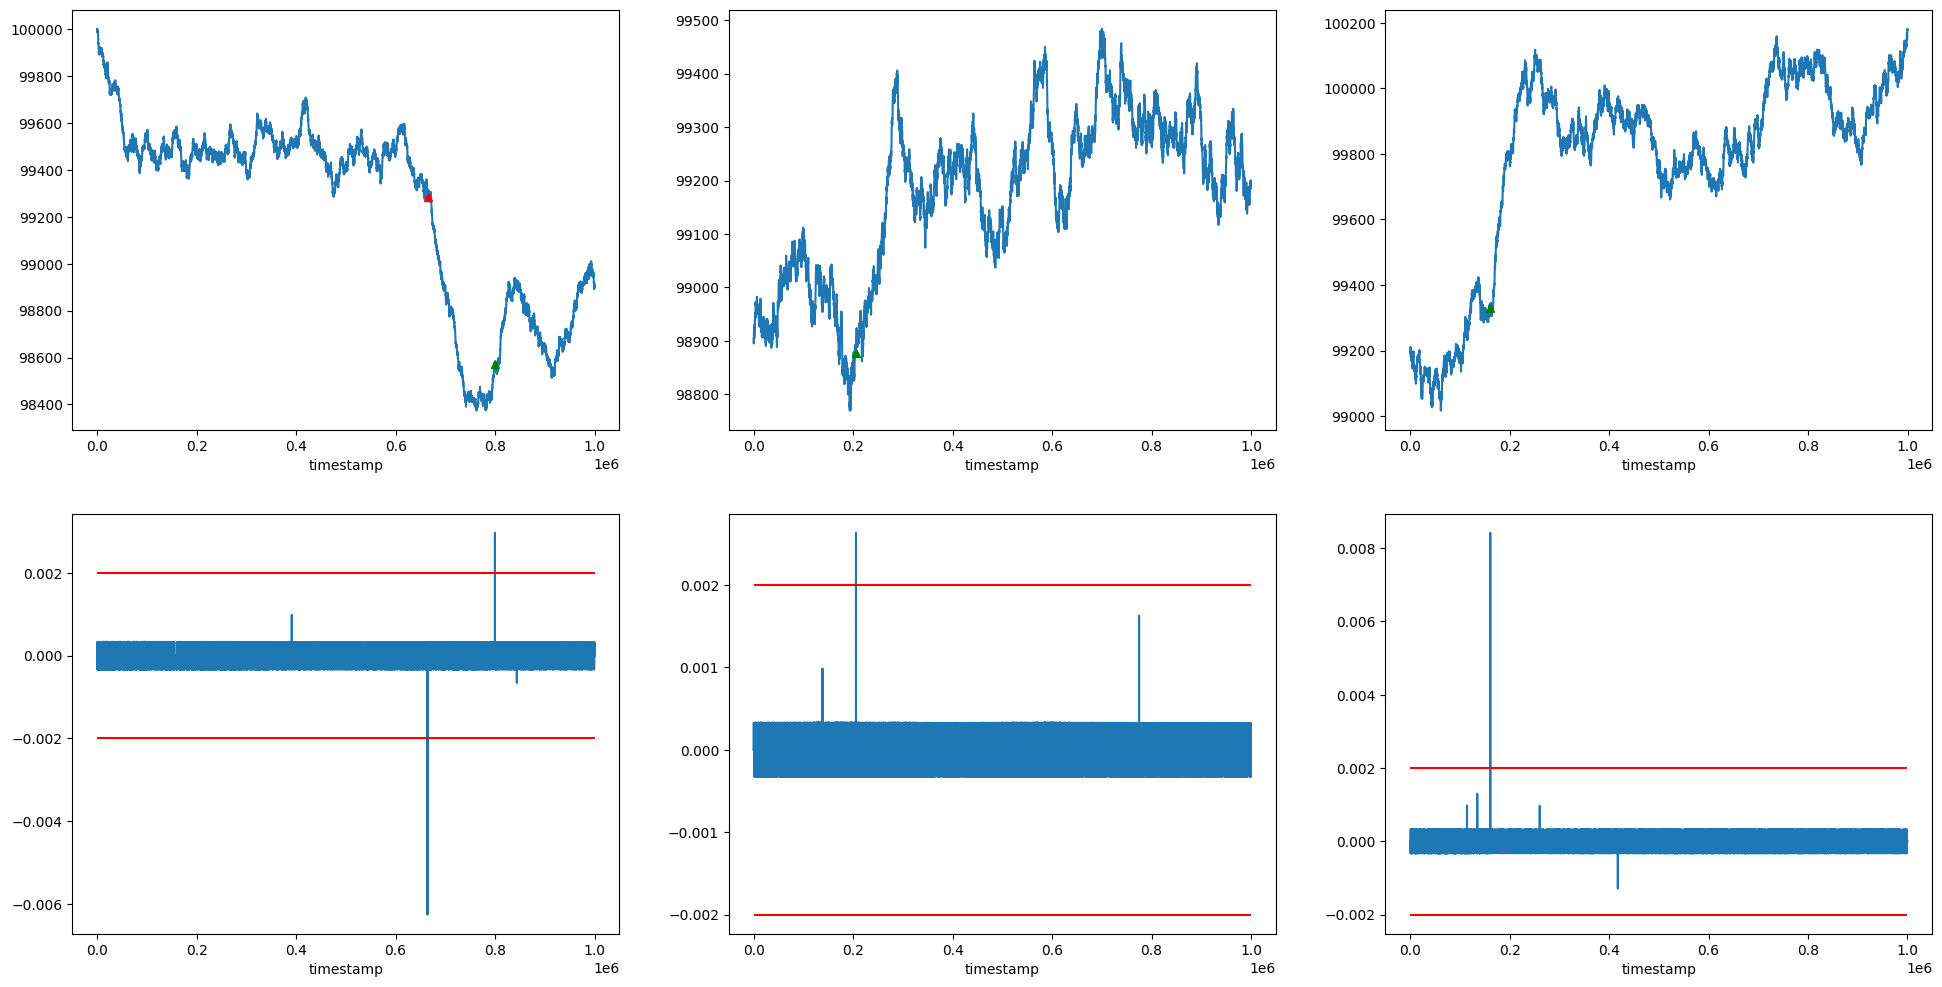

In [8]:
plt.figure(figsize=(24,12))

plt.subplot(2,3,1)
diving_gear_prices0.plot(label = 'mid_price')
diving_gear_prices0[buy_signal0].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices0[sell_signal0].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,4)
dolphin_signal0.plot()
plt.hlines([0.002, -0.002], 0,1e6, colors=['red'])

plt.subplot(2,3,2)
diving_gear_prices1.plot(label = 'mid_price')
diving_gear_prices1[buy_signal1].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices1[sell_signal1].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,5)
dolphin_signal1.plot()
plt.hlines([0.002, -0.002], 0,1e6, colors=['red'])

plt.subplot(2,3,3)
diving_gear_prices2.plot()
diving_gear_prices2[buy_signal2].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices2[sell_signal2].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,6)
dolphin_signal2.plot()
plt.hlines([0.002, -0.002], 0,1e6, colors=['red'])

# Identifying closing position

In [116]:
diving_gear_prices_pct_change0 = diving_gear_prices0.pct_change(1).rolling(200).mean()
diving_gear_prices_pct_change0 = diving_gear_prices_pct_change0.fillna(diving_gear_prices_pct_change0.mean())

diving_gear_prices_pct_change1 = diving_gear_prices1.pct_change(1).rolling(200).mean()
diving_gear_prices_pct_change1 = diving_gear_prices_pct_change1.fillna(diving_gear_prices_pct_change1.mean())

diving_gear_prices_pct_change2 = diving_gear_prices2.pct_change(1).rolling(200).mean()
diving_gear_prices_pct_change2 = diving_gear_prices_pct_change2.fillna(diving_gear_prices_pct_change2.mean())

In [122]:
def find_closing_times(diving_gear_prices_pct_change, buy_signal, sell_signal, start_verifying_index):
    data_long = diving_gear_prices_pct_change.rolling(3).apply(lambda x: all(x < 0)) ## for long positions
    data_short = diving_gear_prices_pct_change.rolling(3).apply(lambda x: all(x > 0)) ## for short positions

    closing_long = [0] * len(buy_signal)
    closing_short = [0] * len(sell_signal)

    for i, start_long_index in enumerate(buy_signal):
        for index in range(start_long_index + start_verifying_index * 1_000, 1_000_000, 1_000):
            if data_long[index] == 1:
                closing_long[i] = index
                break

    for i, start_short_index in enumerate(sell_signal):
        for index in range(start_short_index+ start_verifying_index * 1_000, 1_000_000, 1_000):
            if data_short[index] == 1:
                closing_short[i] = index
                break

    return closing_long, closing_short

In [123]:
close_long0, close_short0 = find_closing_times(diving_gear_prices_pct_change0, buy_signal0, sell_signal0, 20)
close_long1, close_short1 = find_closing_times(diving_gear_prices_pct_change1, buy_signal1, sell_signal1, 20)
close_long2, close_short2 = find_closing_times(diving_gear_prices_pct_change2, buy_signal2, sell_signal2, 20)

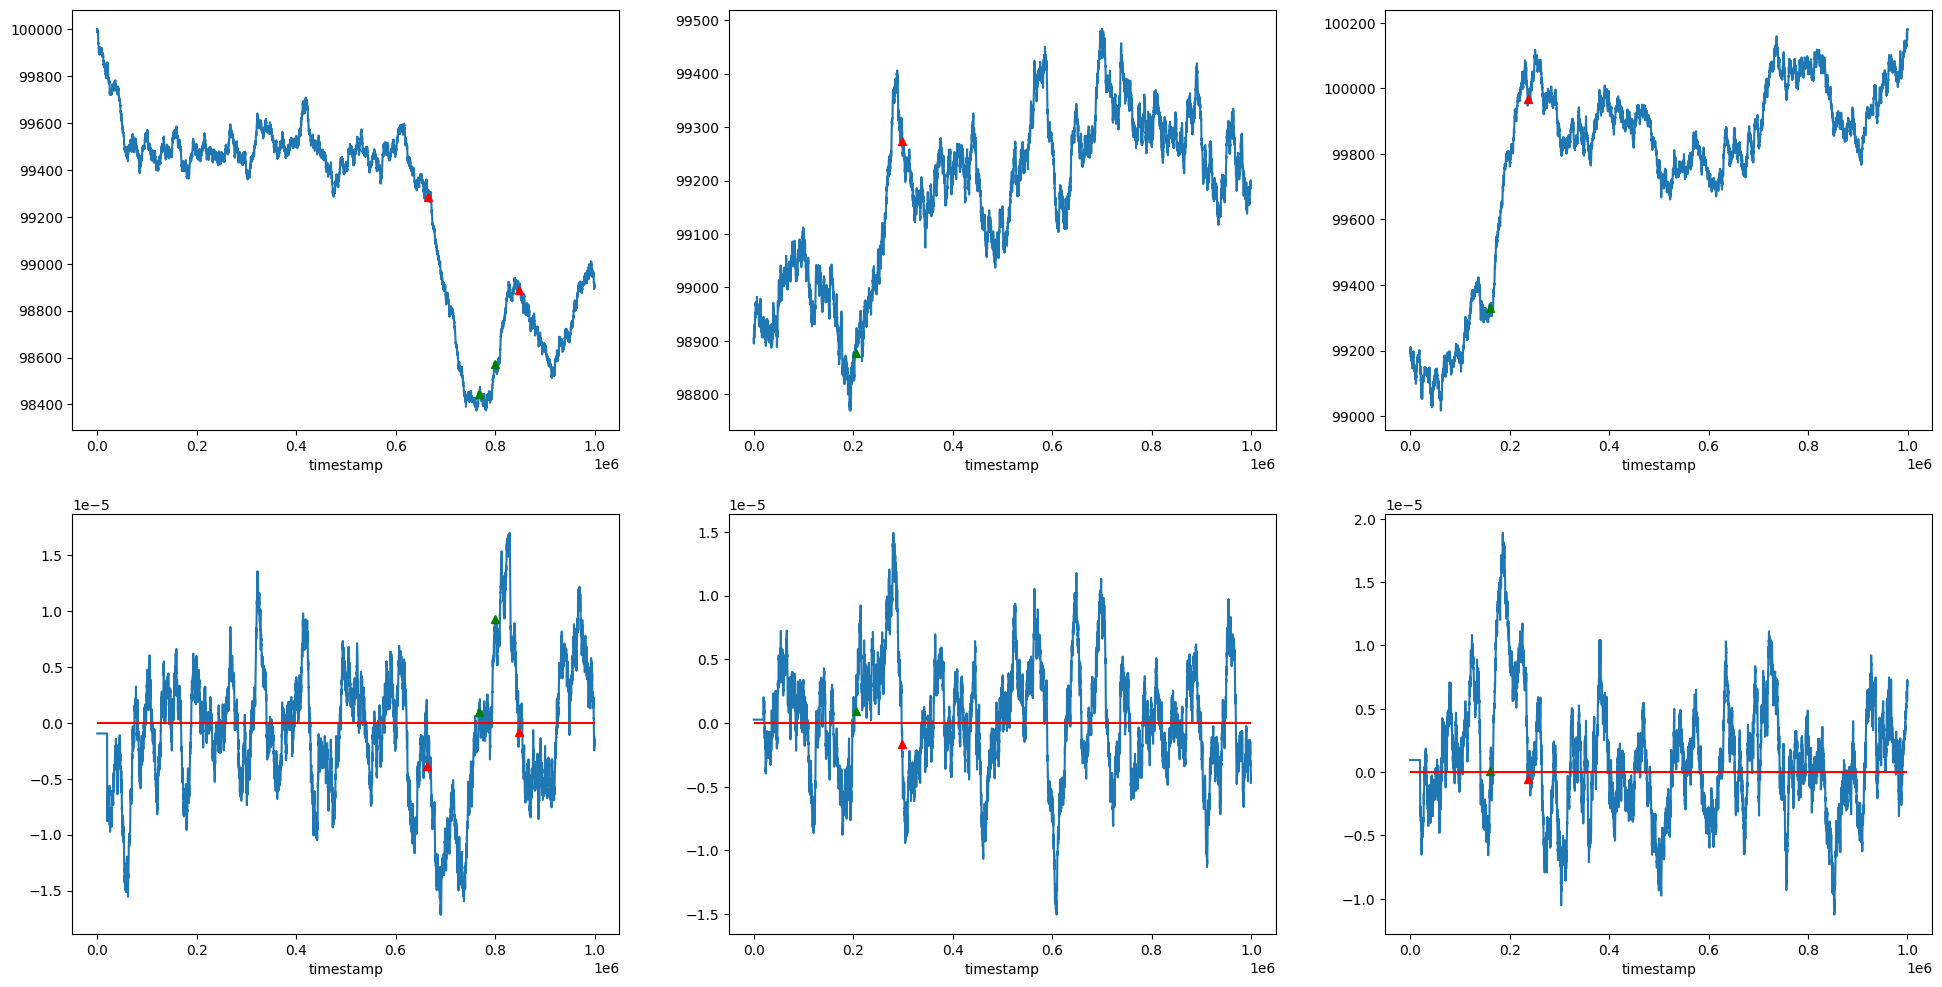

In [125]:
plt.figure(figsize=(24,12))

# Day 0
plt.subplot(2,3,1)
diving_gear_prices0.plot(label = 'mid_price')
diving_gear_prices0[buy_signal0].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices0[sell_signal0].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

# Adding closing posiitons
diving_gear_prices0[close_short0].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices0[close_long0].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,4)
diving_gear_prices_pct_change0.plot()
diving_gear_prices_pct_change0[buy_signal0].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices_pct_change0[sell_signal0].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)
plt.hlines([0], 0,1e6, colors=['red'])
# Adding closing positions
diving_gear_prices_pct_change0[close_short0].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices_pct_change0[close_long0].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

# Day 1
plt.subplot(2,3,2)
diving_gear_prices1.plot(label = 'mid_price')
diving_gear_prices1[buy_signal1].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices1[sell_signal1].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

# Adding closing posiitons
diving_gear_prices1[close_short1].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices1[close_long1].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,5)
diving_gear_prices_pct_change1.plot()
diving_gear_prices_pct_change1[buy_signal1].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices_pct_change1[sell_signal1].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)
plt.hlines([0], 0,1e6, colors=['red'])
# Adding closing positions
diving_gear_prices_pct_change1[close_short1].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices_pct_change1[close_long1].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

# Day 3
plt.subplot(2,3,3)
diving_gear_prices2.plot(label = 'mid_price')
diving_gear_prices2[buy_signal2].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices2[sell_signal2].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)
# Adding closing posiitons
diving_gear_prices2[close_short2].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices2[close_long2].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,6)
diving_gear_prices_pct_change2.plot()
diving_gear_prices_pct_change2[buy_signal2].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices_pct_change2[sell_signal2].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)
# Adding closing positions
diving_gear_prices_pct_change2[close_short2].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices_pct_change2[close_long2].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.hlines([0], 0,1e6, colors=['red'])